In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools
import hssm
import nutpie
import os, sys


In [3]:
#Set up plotting themes
sns.set_theme(context = 'paper', style = 'darkgrid', palette = 'colorblind', font_scale=1.5, font='serif')

# Robust Exposure RT fits

In [3]:
dv = 'accuracy'
if dv == 'accuracy':
    family = 'bernoulli'
else:
    family = 'gaussian'
#Read exposure data. Rename some columns for bambi requirements
df_clean_exposure = pd.read_csv('df_clean_exposure.csv')
df_clean_exposure['node_type'] = df_clean_exposure['node type']
df_clean_exposure['log_trials'] = np.log(df_clean_exposure['trials']+1)

#Model fit and save
bmb_exposure_accuracy_model = bmb.Model(f'{dv} ~ log_trials*condition*node_type + (1|participant)', data = df_clean_exposure, family = family)
samples = bmb_exposure_accuracy_model.fit(nuts_sampler = 'nutpie')

Modeling the probability that accuracy==1


<Axes: xlabel='log_rt', ylabel='Count'>

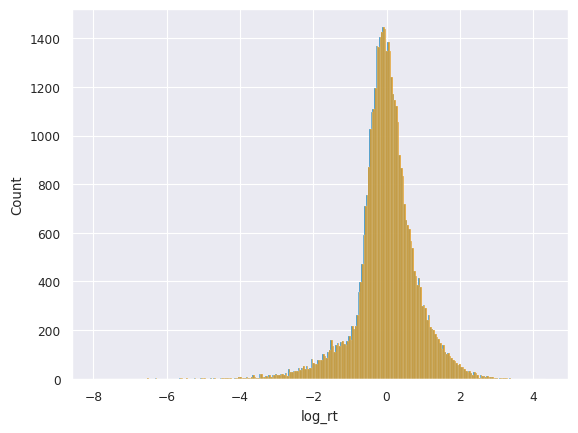

In [59]:
df_clean_exposure['log_rt'] = np.log(df_clean_exposure['rt'])
df_clean_exposure['shifted_log_rt'] = df_clean_exposure['log_rt'] - df_clean_exposure['log_rt'].mean()

sns.histplot(df_clean_exposure['log_rt'])
sns.histplot(df_clean_exposure['shifted_log_rt'])
# sns.histplot(df_clean_exposure['rt'])


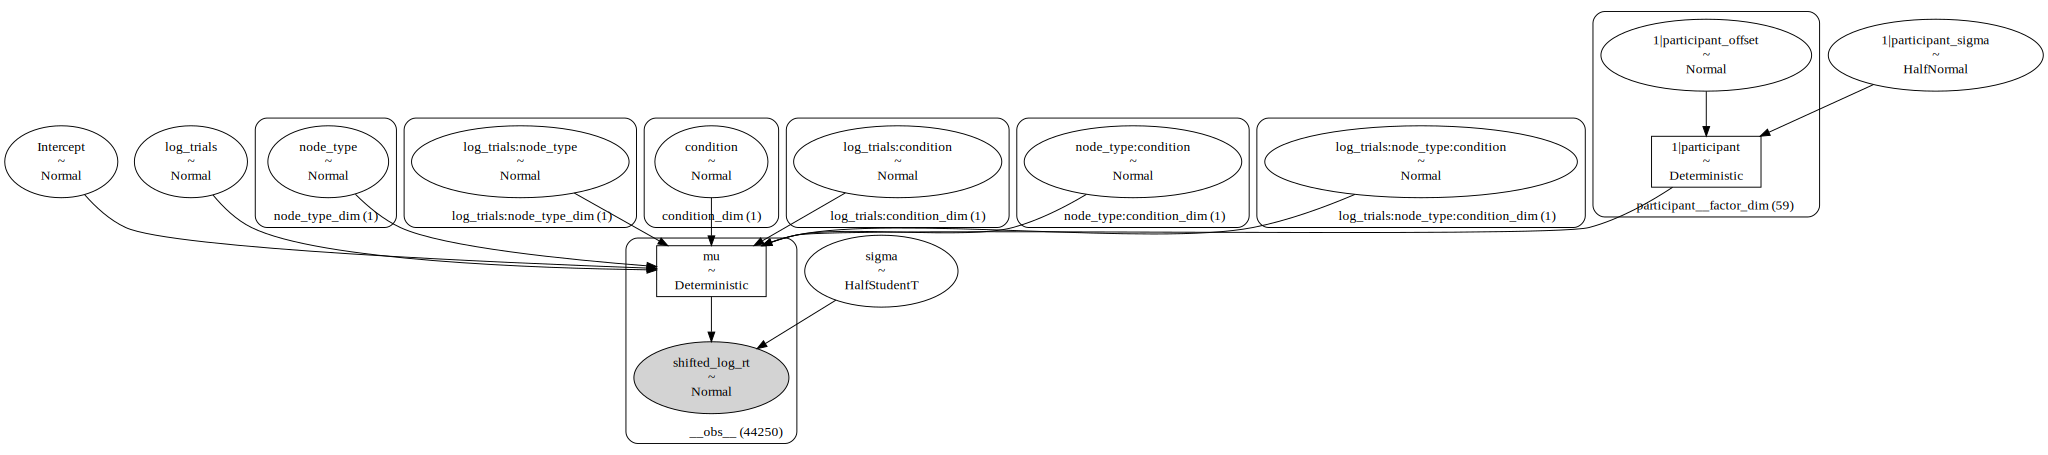

In [87]:
bmb_rt_model = bmb.Model(
    'shifted_log_rt ~ log_trials*node_type*condition + (1|participant)', 
    data = df_clean_exposure,
)
bmb_rt_model.build()
bmb_rt_model.graph()

In [90]:
samples_unstructuerd = bmb_rt_model.fit(tune=2000)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:04:04

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 245 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [89]:
az.summary(samples_unstructuerd, filter_vars='like', var_names = ['trials', 'condition', 'trials', 'node_type', 'Intercept'], hdi_prob=.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.13,0.11,0.93,1.33,0.01,0.01,134.54,305.70,1.05
condition[unstructured],0.06,0.15,-0.23,0.37,0.01,0.01,120.86,151.96,1.04
log_trials,-0.21,0.01,-0.22,-0.19,0.00,0.00,357.61,378.18,1.01
log_trials:condition[unstructured],0.00,0.01,-0.02,0.02,0.00,0.00,399.60,302.08,1.01
log_trials:node_type[nonboundary],0.01,0.01,-0.01,0.03,0.00,0.00,330.38,368.11,1.01
"log_trials:node_type:condition[nonboundary, unstructured]",-0.02,0.01,-0.05,0.00,0.00,0.00,361.75,471.84,1.01
node_type[nonboundary],-0.06,0.05,-0.17,0.04,0.00,0.00,330.18,358.94,1.01
"node_type:condition[nonboundary, unstructured]",0.12,0.07,-0.04,0.25,0.00,0.00,363.16,497.10,1.01


# Balance Integration

In [7]:
#reads in all the NAMES of the data files from the 'data' folder. 
df_clean_exposure = pd.read_csv('df_clean_exposure.csv')
df_clean_memory = pd.read_csv('df_clean_memory.csv')

#Group for each stimulus
df_clean_exposure_grouped = df_clean_exposure.groupby(['stim chosen', 'participant', 'block']).mean(numeric_only=True).reset_index()

#Group for each block (across stimulus, used to assign exposure accuracy to 'new' items for recog test) 
df_clean_exposure_acc = df_clean_exposure_grouped.groupby(['participant', 'block']).mean(numeric_only=True).reset_index()

#Join first to incorporate exposure accuracy for old stimuli
df_clean_memory_joined = pd.merge(df_clean_memory, df_clean_exposure_grouped, left_on=['participant', 'test item', 'block'], 
                                  right_on=['participant', 'stim chosen', 'block'], suffixes=('', '_exposure'), how = 'left')


#Replace the new stimuli exposure accuracy NaNs with averages for that participant/block.
for ppt in df_clean_exposure_acc.participant.unique():
    for b in range(3):
        df_clean_memory_joined.loc[((df_clean_memory_joined.node_type == 'new') & (df_clean_memory_joined.participant == ppt) & (df_clean_memory_joined.block == b)), 'accuracy_exposure'] = df_clean_exposure_acc.loc[((df_clean_exposure_acc.participant == ppt)&(df_clean_exposure_acc.block == b)), 'accuracy'].values[0]

#Remove trials that are too quick (<250 miliseconds)
df_clean_memory_joined = df_clean_memory_joined.loc[((df_clean_memory_joined.rt > 0.25))].reset_index(drop=True)


In [8]:
# df_clean_memory_joined['z_accuracy'] = (df_clean_memory_joined['accuracy'] - df_clean_memory_joined['accuracy'].mean())/df_clean_memory_joined['accuracy'].std()
# df_clean_memory_joined['z_rt'] = (df_clean_memory_joined['log_rt'] - df_clean_memory_joined['rt'].mean())/df_clean_memory_joined['rt'].std()
# df_clean_memory_joined['BIS'] = df_clean_memory_joined['z_accuracy'] - df_clean_memory_joined['z_rt']

In [9]:
df_clean_memory_joined_grouped = df_clean_memory_joined.groupby(['participant', 'node_type', 'condition', 'block']).mean(numeric_only=True).reset_index()

In [10]:
df_clean_memory_joined_grouped['S_rt'] = df_clean_memory_joined.groupby(['participant', 'node_type', 'condition', 'block']).std(numeric_only=True).reset_index()['rt']
df_clean_memory_joined_grouped['S_accuracy'] = df_clean_memory_joined.groupby(['participant', 'node_type', 'condition', 'block']).std(numeric_only=True).reset_index()['accuracy']

df_clean_memory_joined_grouped['sum_rt'] = df_clean_memory_joined.groupby(['participant', 'node_type', 'condition', 'block']).sum(numeric_only=True).reset_index()['rt']
df_clean_memory_joined_grouped['sum_accuracy'] = df_clean_memory_joined.groupby(['participant', 'node_type', 'condition', 'block']).sum(numeric_only=True).reset_index()['accuracy']

df_clean_memory_joined_grouped['z_accuracy'] = stat.zscore(df_clean_memory_joined_grouped['accuracy'])
df_clean_memory_joined_grouped['z_rt'] = stat.zscore(df_clean_memory_joined_grouped['rt'])


df_clean_memory_joined_grouped['BIS'] = 2**(df_clean_memory_joined_grouped['z_accuracy']*np.std(df_clean_memory_joined_grouped['accuracy']) - df_clean_memory_joined_grouped['z_rt']*np.std(df_clean_memory_joined_grouped['rt']))    


<Axes: xlabel='BIS', ylabel='Count'>

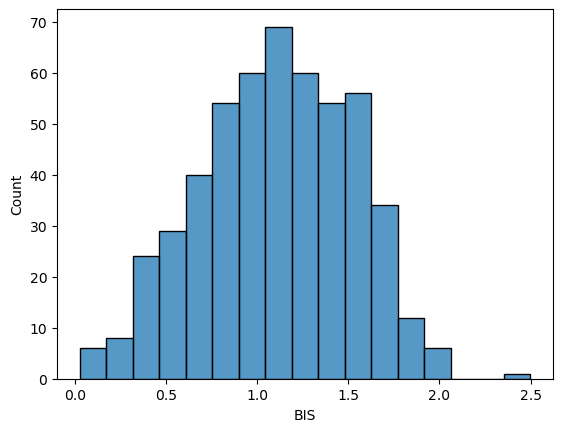

In [12]:
sns.histplot(df_clean_memory_joined_grouped['BIS'])

In [31]:
post_diff = {}
for cond in ['structured', 'unstructured']:
    bis_model = bmb.Model(
        'BIS~ 0 + node_type:block + accuracy_exposure + (1|participant_id)', 
        data = df_clean_memory_joined_grouped.loc[df_clean_memory_joined_grouped['condition'] == cond])
    samples = bis_model.fit()
    post_diff[cond] = samples['posterior'].sel({'node_type:block_dim':'boundary'})['node_type:block'] - samples['posterior'].sel({'node_type:block_dim':'nonboundary'})['node_type:block']

    
    
# bis_model.graph()


Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:04

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


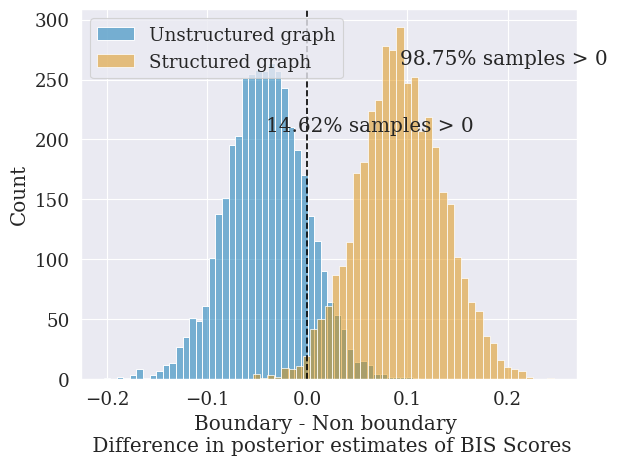

In [83]:
g = sns.histplot(np.ravel(post_diff['unstructured']), alpha = .5, label = 'Unstructured graph')
sns.histplot(np.ravel(post_diff['structured']), alpha = .5, label='Structured graph')
g.axvline(x = 0, ls = '--', color = 'black')

for cond in ['unstructured', 'structured']:
    g.text(
        x = np.mean(post_diff[cond]), 
        y = 230 + np.random.normal(10, 20), 
        s=f"{str(np.mean(np.ravel(post_diff[cond])>0)*100)[:5]}% samples > 0" 
    )
plt.legend(loc = 'upper left')

g.set_xlabel('Boundary - Non boundary \n Difference in posterior estimates of BIS Scores')
plt.savefig('figures/bis_differences.png', dpi=300)


# Bootstrapping

In [2]:
df_clean_memory_joined = pd.read_csv('df_clean_memory_joined.csv').drop('Unnamed: 0', axis = 1)

In [4]:
boot_estimates_structured = {'boundary':[], 'non boundary':[], 'new':[]}
boot_estimates_unstructured = {'boundary':[], 'non boundary':[], 'new':[]}

def extract_empirical_nulls(boot_estimates = {'boundary':[], 'non boundary':[], 'new':[]}, condition='structured'):
    for i in range(100):
        try:
            mean_estimate = pd.read_csv(f'model_results/bootstrap/{condition}/{i}.csv')

            boot_estimates['boundary'].append(mean_estimate.loc[mean_estimate['Unnamed: 0'] == 'v_node_type[boundary]']['mean'].values[0])
            boot_estimates['non boundary'].append(mean_estimate.loc[mean_estimate['Unnamed: 0'] == 'v_node_type[nonboundary]']['mean'].values[0])    
            boot_estimates['new'].append(mean_estimate.loc[mean_estimate['Unnamed: 0'] == 'v_node_type[new]']['mean'].values[0])    
        except:
            print(i)
            continue
    return boot_estimates

    
boot_estimates_structured = extract_empirical_nulls(boot_estimates = boot_estimates_structured, condition ='structured')
boot_estimates_unstructured = extract_empirical_nulls(boot_estimates = boot_estimates_unstructured, condition ='unstructured')


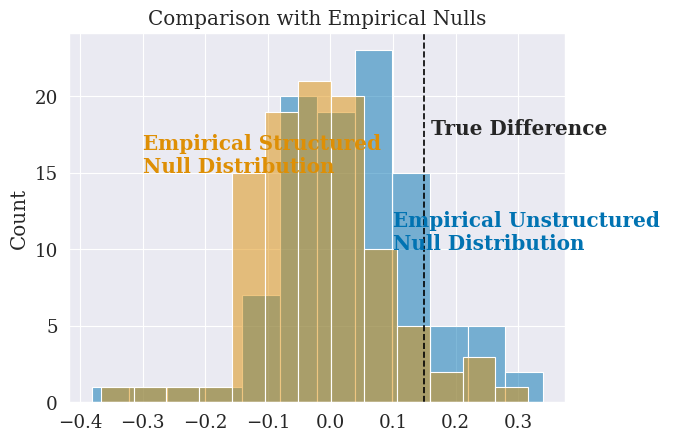

In [7]:
ax = sns.histplot(np.array(boot_estimates_unstructured['boundary']) - np.array(boot_estimates_unstructured['non boundary']), alpha = 0.5, color = 'C0')
sns.histplot(np.array(boot_estimates_structured['boundary']) - np.array(boot_estimates_structured['non boundary']), ax = ax, alpha = 0.5, color = 'C1')
ax.axvline(x = 0.15, ls = '--', color = 'black')
ax.text(s = 'True Difference', x = 0.16, y = 17.5, fontweight = 'heavy')
ax.text(s = 'Empirical Structured \nNull Distribution', x = -0.3, y = 15, color = 'C1', fontweight='bold')
ax.text(s = 'Empirical Unstructured \nNull Distribution', x = 0.1, y = 10, color = 'C0', fontweight = 'bold')
ax.set_title('Comparison with Empirical Nulls')
plt.savefig('figures/bootstrapping_figure.png', dpi = 300)

In [56]:
np.mean((np.array(boot_estimates_structured['boundary']) - np.array(boot_estimates_structured['non boundary']))>0.15), np.mean((np.array(boot_estimates_unstructured['boundary']) - np.array(boot_estimates_unstructured['non boundary']))>0.15)

(0.06, 0.1326530612244898)

# Individual participant predictions

In [146]:
ddm_model_samples_structured = az.from_netcdf(f'model_results/posteriors/hssm_posteriors/structured_v~acc_exp-nodetype-nodetype_ppt_a~block-_ppt_z~block-_ppt_t~_ppt.nc')

In [5]:
participant_ids = ddm_model_samples_structured['posterior']['participant_id__factor_dim'].values

In [6]:
df_clean_memory_joined = pd.read_csv('df_clean_memory_joined.csv').drop('Unnamed: 0', axis = 1)


In [12]:
ppt_id = ddm_model_samples_structured['posterior']['v_C(node_type)|participant_id__factor_dim'].values

In [134]:
mean_ppt_nt = []
for ppt in ppt_id:
    mean_ppt_nt.append(np.mean(ddm_model_samples_structured['posterior'].sel({'v_C(node_type)|participant_id__factor_dim':ppt, 'v_C(node_type)|participant_id__expr_dim': 'nonboundary'})['v_C(node_type)|participant_id'].values))

mean_ppt_nt_df = pd.DataFrame({
    'participant': ppt_id.astype(float),
    'drift estimates': mean_ppt_nt
}
)

In [172]:
grouped_df_clean_memory_joined = df_clean_memory_joined.groupby(['condition', 'participant', 'node_type']).mean(numeric_only=True).reset_index()
grouped_df_clean_memory_joined = grouped_df_clean_memory_joined.loc[grouped_df_clean_memory_joined['condition'] == 'structured']

boundary_mem = grouped_df_clean_memory_joined.loc[grouped_df_clean_memory_joined['node_type'] == 'boundary', ['condition', 'participant', 'node_type', 'rt_exposure', 'accuracy_exposure', 'rt', 'accuracy']].reset_index(drop=True)
nonboundary_mem = grouped_df_clean_memory_joined.loc[grouped_df_clean_memory_joined['node_type'] == 'nonboundary', ['condition', 'participant', 'node_type', 'rt_exposure', 'accuracy_exposure', 'rt', 'accuracy']].reset_index(drop=True)

In [173]:
grouped_boundary_nonboundary_mem = pd.merge(boundary_mem, nonboundary_mem, on = ['condition', 'participant'], suffixes = ('_boundary', '_nonboundary'))
grouped_boundary_nonboundary_mem['rt_diff'] = grouped_boundary_nonboundary_mem['rt_exposure_boundary'] - grouped_boundary_nonboundary_mem['rt_exposure_nonboundary']
grouped_boundary_nonboundary_mem_w_drift = pd.merge(grouped_boundary_nonboundary_mem, mean_ppt_nt_df)[['condition', 'participant', 'rt_diff', 'drift estimates']]

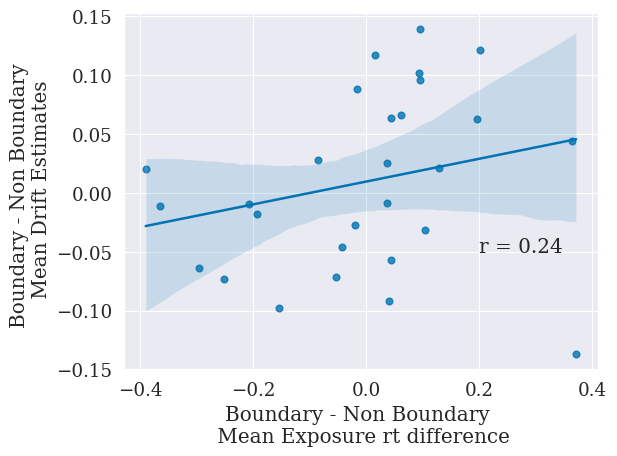

In [190]:
ax = sns.regplot(
    x = 'rt_diff',
    y = 'drift estimates',
    data = grouped_boundary_nonboundary_mem_w_drift
)
ax.set_ylabel('Boundary - Non Boundary \n Mean Drift Estimates')
ax.set_xlabel('Boundary - Non Boundary \n Mean Exposure rt difference')
ax.text(x = 0.2, y = -0.05, s = 'r = 0.24')
plt.tight_layout()
plt.savefig('figures/indiv_differences.png', dpi = 300)

In [177]:
grouped_boundary_nonboundary_mem_w_drift['drift_estimates'] = grouped_boundary_nonboundary_mem_w_drift['drift estimates']
model = bmb.Model('drift_estimates ~ rt_diff', data = grouped_boundary_nonboundary_mem_w_drift)
model_samples = model.fit()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:01

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'rt_diff'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

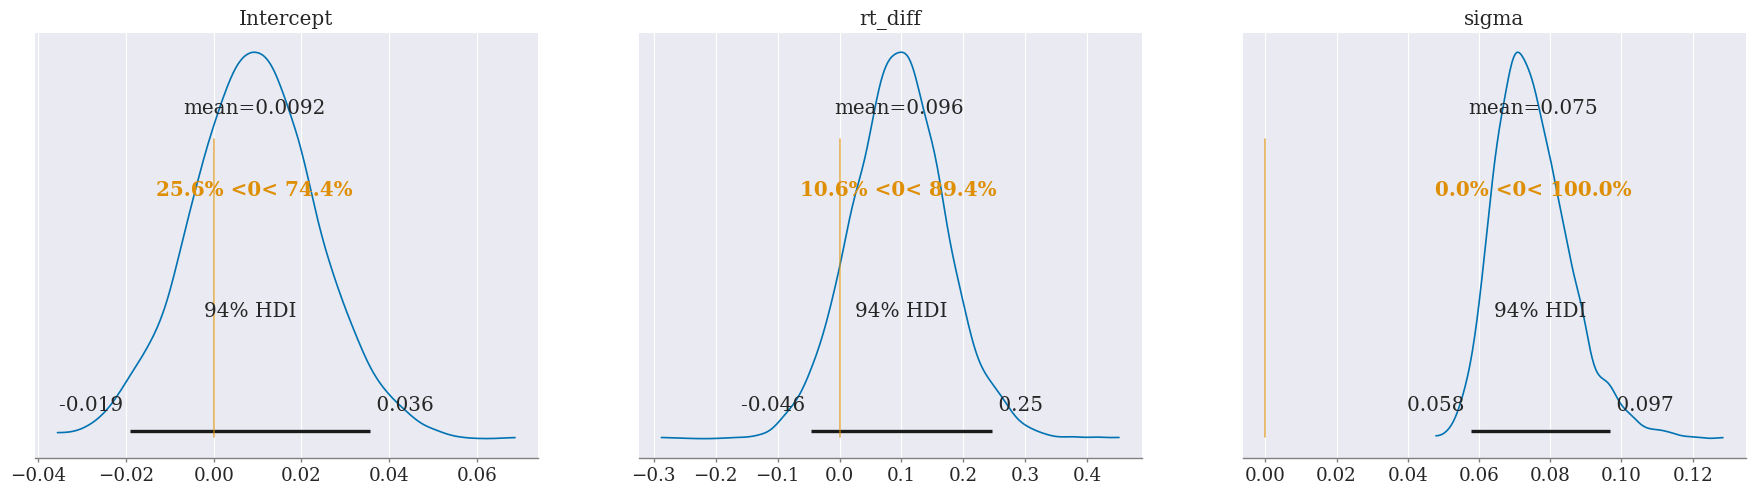

In [178]:
az.plot_posterior(model_samples, ref_val=0)

In [166]:
corr_posteriors = model_samples['posterior']['rt_diff'] * grouped_boundary_nonboundary_mem_w_drift['rt_diff'].std()/grouped_boundary_nonboundary_mem_w_drift['drift_estimates'].std()
np.mean(np.ravel(corr_posteriors)>0)


0.903

In [180]:
az.summary(
    corr_posteriors,
    stat_focus='mean',
    hdi_prob=.95
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rt_diff,0.248,0.194,-0.14,0.62,0.003,0.002,4478.0,2927.0,1.0


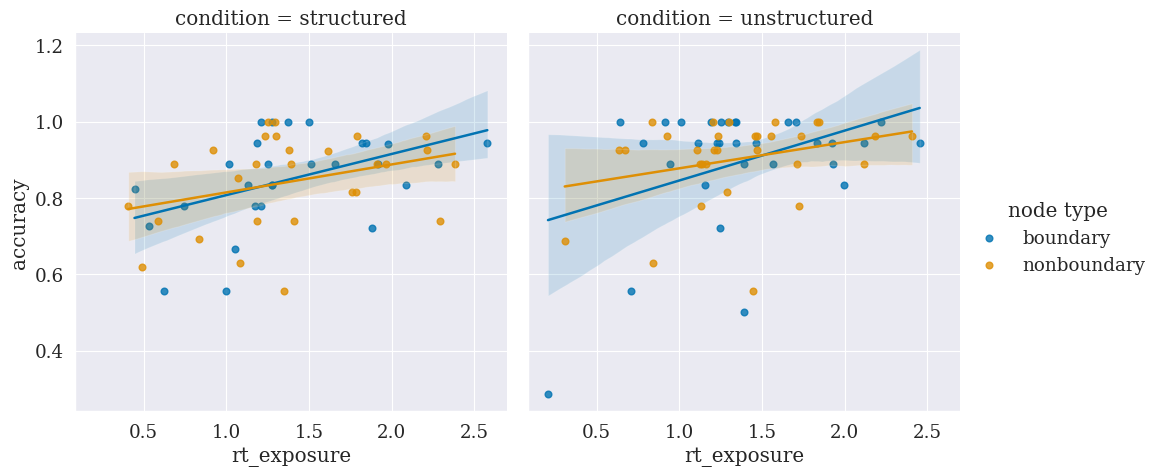

In [65]:
sns.lmplot(
    y = 'accuracy',
    x = 'rt_exposure',
    hue = 'node type',
    col = 'condition',
    data = df_clean_memory_joined_grouped.loc[df_clean_memory_joined_grouped['node type']!='new'],
    # lowess=True
)


In [ ]:
bmb_model = bmb.Model()

# Sample from posteriors

In [8]:
df_clean_memory_joined = pd.read_csv('df_clean_memory_joined.csv').drop('Unnamed: 0', axis = 1)
CONDITION = 'structured'


In [9]:
# Specify which participant group
# ddm_model_samples_unstructured = az.from_netcdf(f'hssm_results/unstructured_v~acc_exp-nodetype-nodetype|ppt_a~block-|ppt_z~block-|ppt_t~|ppt.nc')
ddm_model_samples_structured = az.from_netcdf(f'model_results/posteriors/hssm_posteriors/structured_v~acc_exp-nodetype-nodetype_ppt_a~block-_ppt_z~block-_ppt_t~_ppt.nc')


In [10]:
ddm_model = hssm.HSSM(noncentered = True, prior_settings = 'safe',  
                      data = df_clean_memory_joined.loc[df_clean_memory_joined.condition == 'structured'],#, ['participant_id', 'response', 'rt', "node_type", "block", "accuracy_exposure"]],  
                      include=[
                                {
                                    "name": "v",
                                    "formula": "v ~ 0 + accuracy_exposure + C(node_type) + (C(node_type)|participant_id)",
                                    # "link": "identity"
                                    # "prior": {"name": "Normal", "mu": 0, "sigma": 0.01},
                                },
                          {
                              "name": "z",
                              "formula": "z ~ C(block) + (1|participant_id)"
                              # "formula": "z ~ "
                          },

                          {
                              "name": "a",
                              "formula": "a ~ C(block) + (1|participant_id)"
                              # "formula": "a ~ (1|participant_id)"

                          },
                          
                          {
                              "name": "t",
                              "formula": "t ~ (1|participant_id)"
                          },
                          
                              ],
                     )


No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


In [11]:
summary_results = az.summary(ddm_model_samples_structured, var_names='~participant', filter_vars='like')

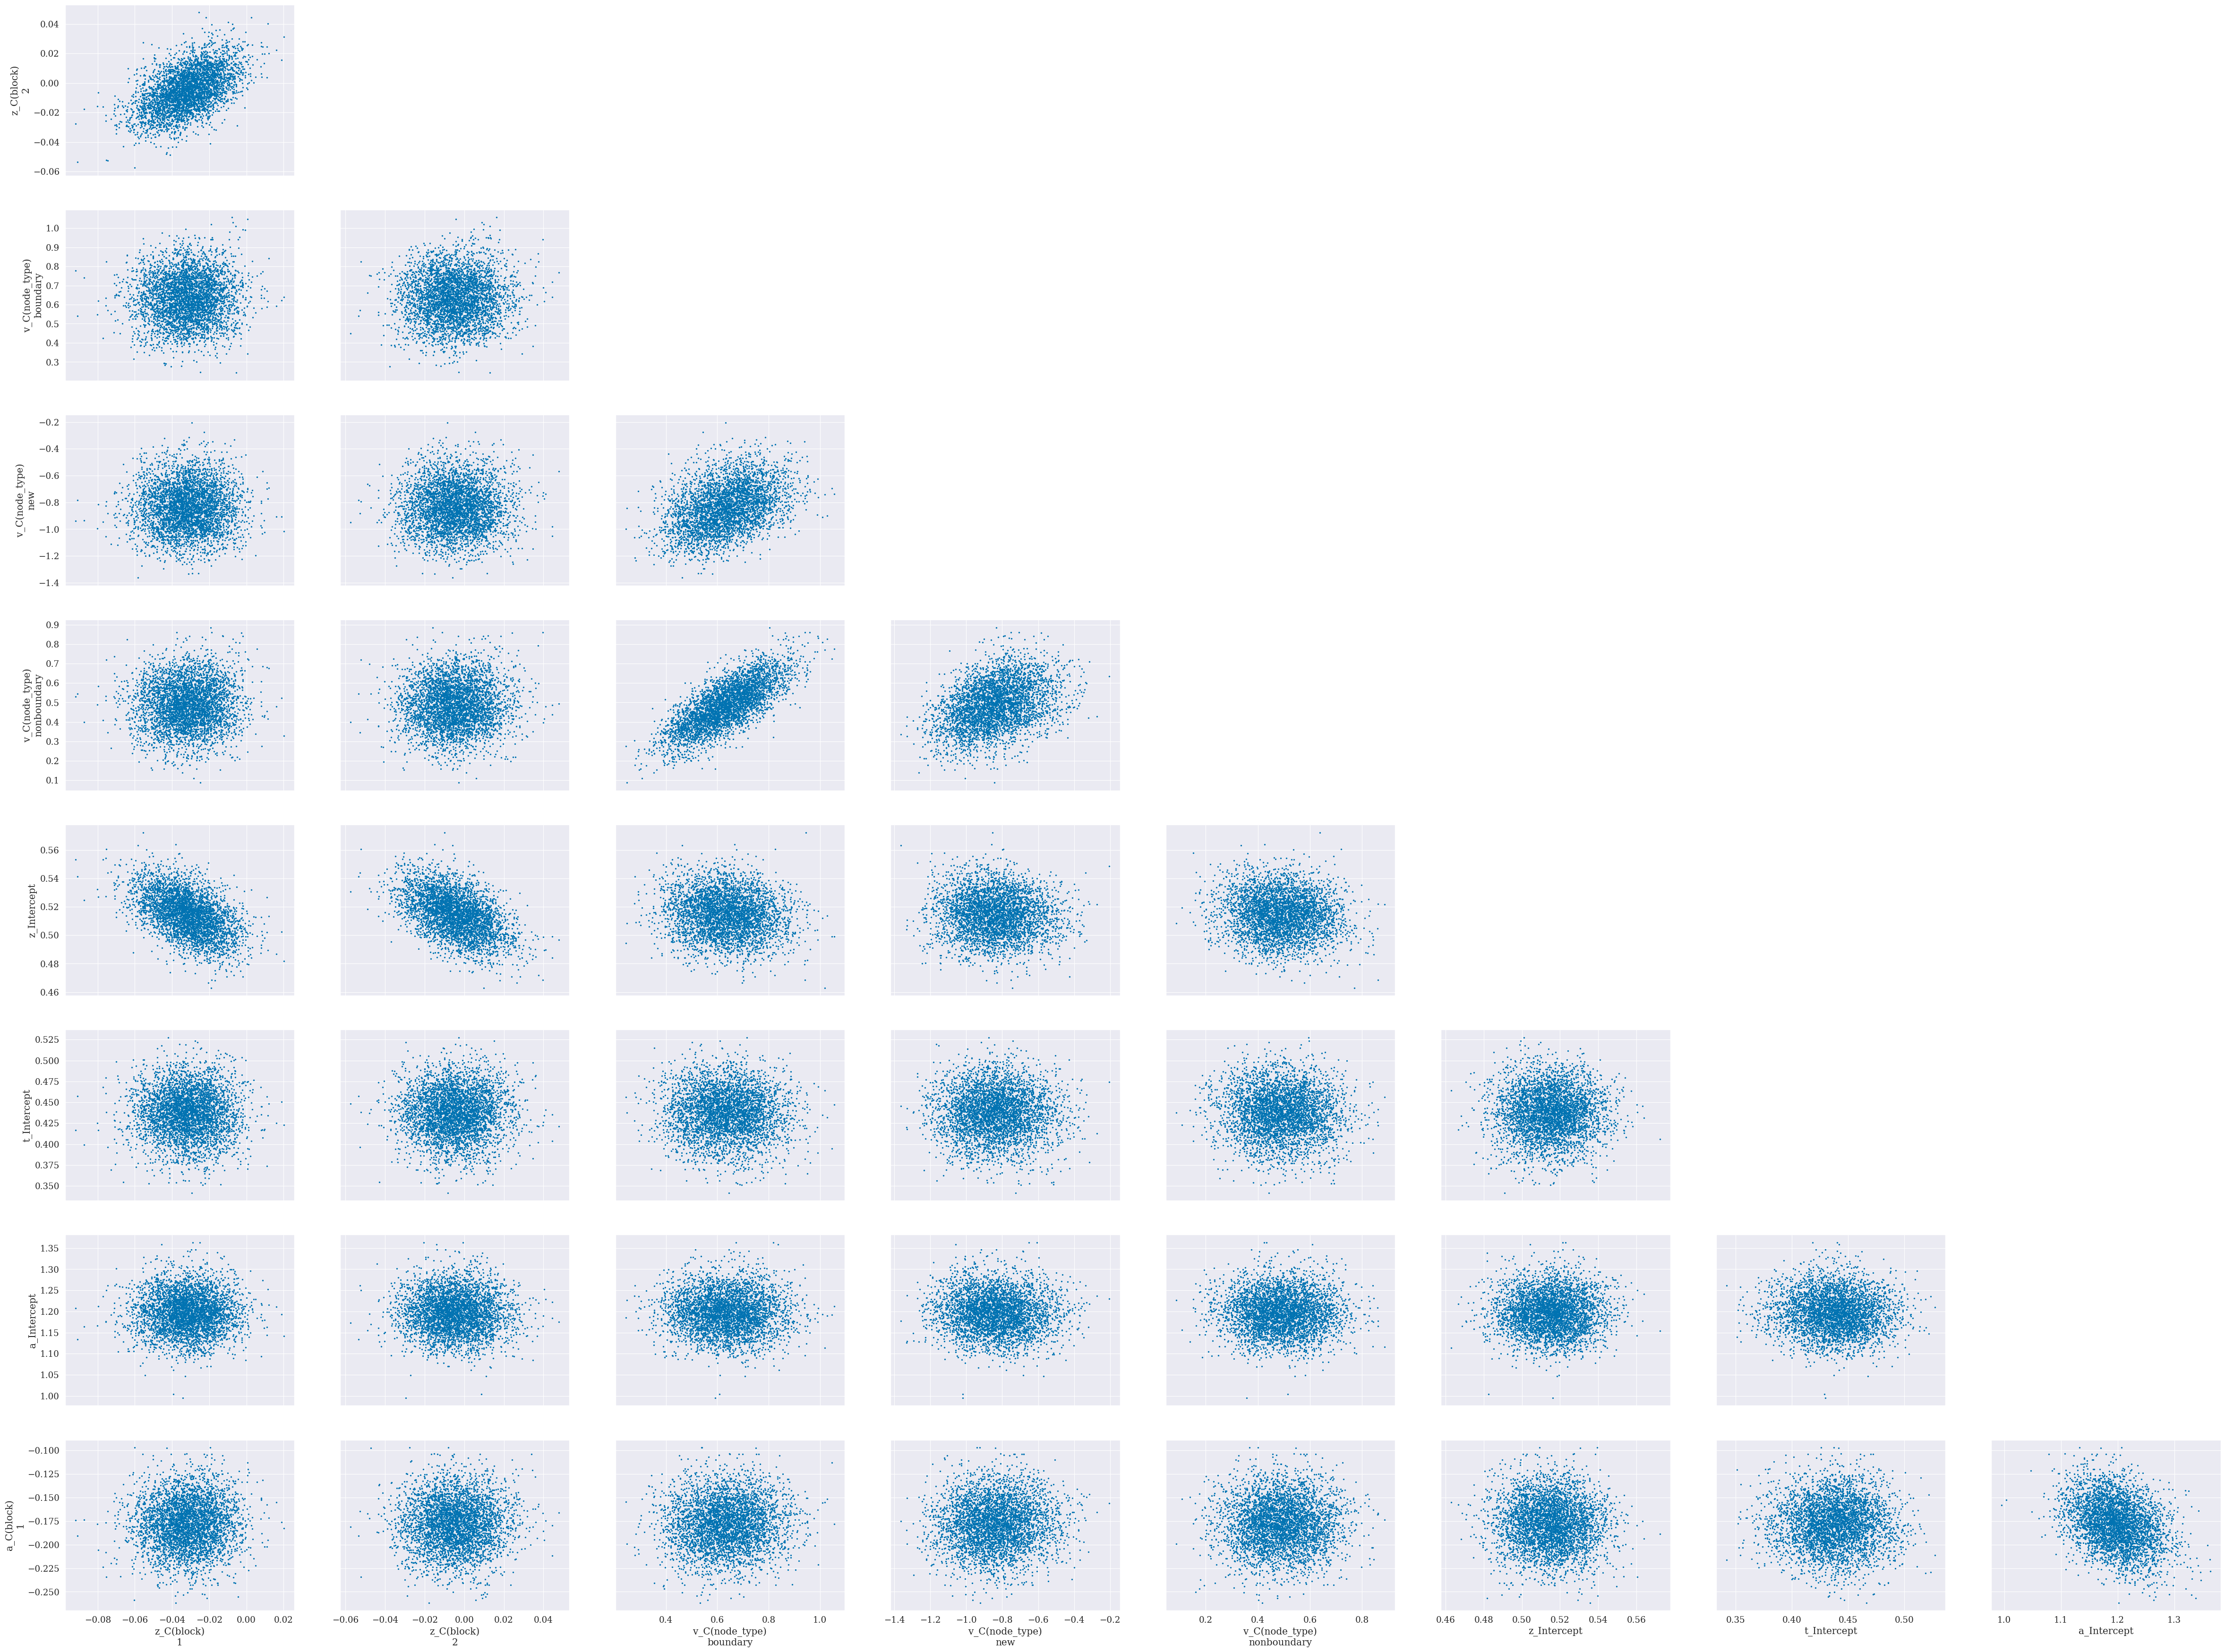

In [12]:
az.plot_pair(ddm_model_samples_structured, var_names='~participant', filter_vars='like')
plt.savefig('figures/param_correlations.png', dpi = 300)

In [13]:
# summary_results

In [15]:
simulated_data_boundary = hssm.simulate_data(model = "ddm", theta={'a':1.198, 'v':0.634, 'z':0.515, 't':0.438}, size = 1000)
simulated_data_boundary['node type'] = 'boundary (v = 0.634)'

simulated_data_nonboundary = hssm.simulate_data(model = "ddm", theta={'a':1.198, 'v':0.489, 'z':0.515, 't':0.438}, size = 1000)
simulated_data_nonboundary['node type'] = 'non boundary (v = 0.489)'

simulated_data = pd.concat([simulated_data_boundary, simulated_data_nonboundary]).reset_index(drop=True)


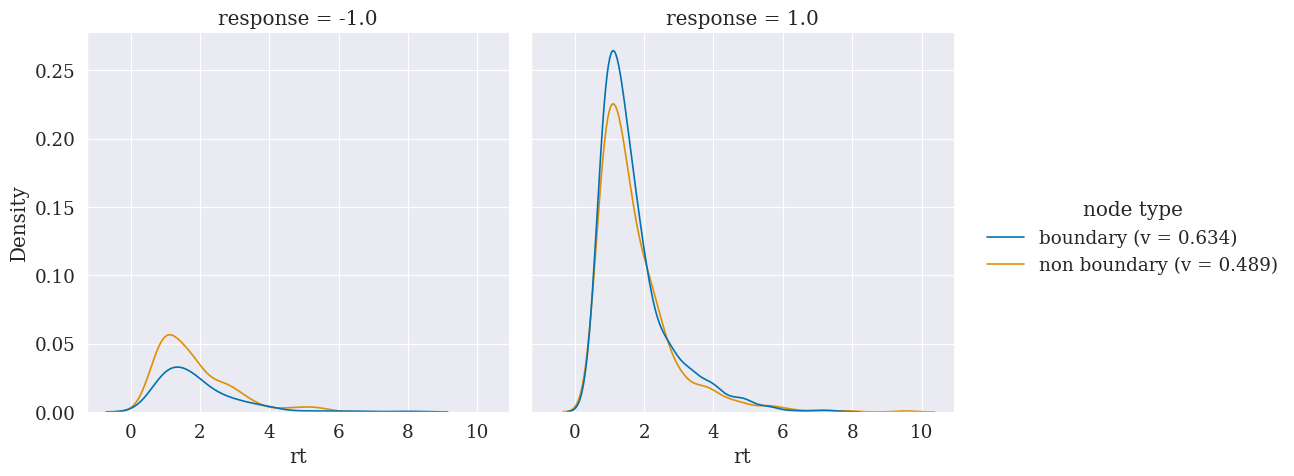

In [16]:
g = sns.displot(
    x = 'rt', 
    col = 'response', 
    hue = 'node type', 
    data = simulated_data, 
    kind = 'kde'
)
plt.savefig('figures/v_marginalized.png', dpi = 300)

In [17]:
simulated_data_a1 = hssm.simulate_data(model = "ddm", theta={'a':1.198, 'v':0.634, 'z':0.515, 't':0.438}, size = 1000)
simulated_data_a1['a'] = '1.198'

simulated_data_a2 = hssm.simulate_data(model = "ddm", theta={'a':1.02, 'v':0.634, 'z':0.515, 't':0.438}, size = 1000)
simulated_data_a2['a'] = '1.02'

simulated_data = pd.concat([simulated_data_a1, simulated_data_a2]).reset_index(drop=True)


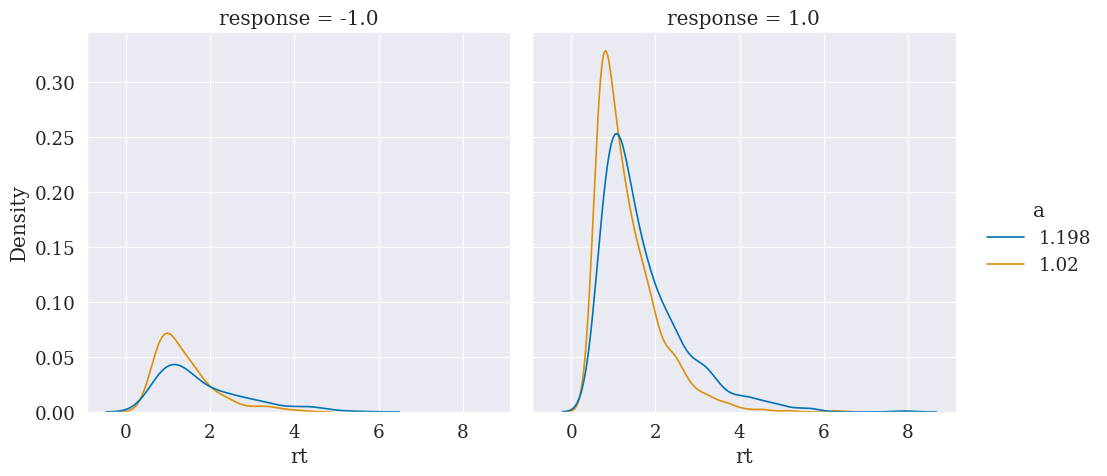

In [18]:
g = sns.displot(
    x = 'rt', 
    col = 'response', 
    hue = 'a', 
    data = simulated_data, 
    kind = 'kde'
)
plt.savefig('figures/a_marginalized.png', dpi = 300)

In [32]:
simulated_data_z1 = hssm.simulate_data(model = "ddm", theta={'a':1.198, 'v':0.634, 'z':0.515, 't':0.438}, size = 1000)
simulated_data_z1['z'] = '0.515'

simulated_data_z2 = hssm.simulate_data(model = "ddm", theta={'a':1.198, 'v':0.634, 'z':0.483, 't':0.438}, size = 1000)
simulated_data_z2['z'] = '0.483'

simulated_data = pd.concat([simulated_data_z1, simulated_data_z2]).reset_index(drop=True)


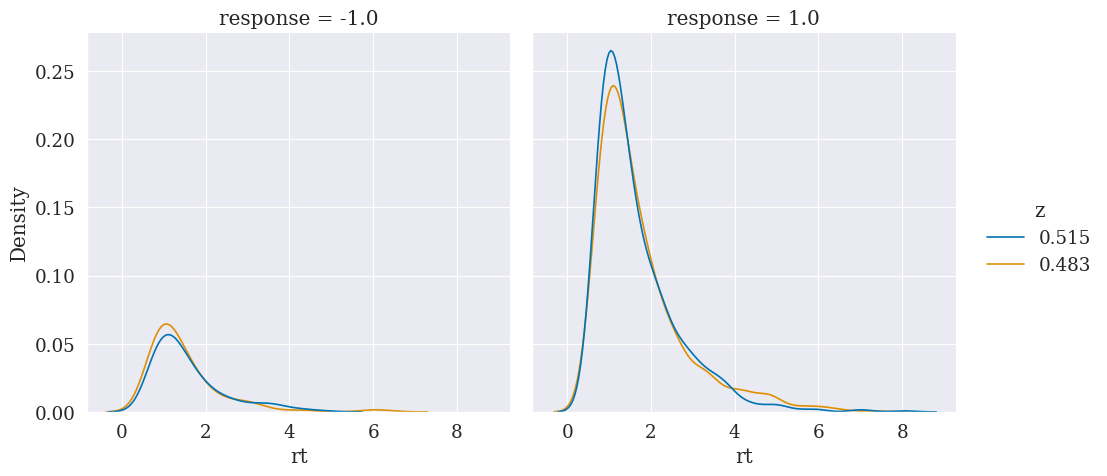

In [33]:
g = sns.displot(
    x = 'rt', 
    col = 'response', 
    hue = 'z', 
    data = simulated_data, 
    kind = 'kde'
)
plt.savefig('figures/z_marginalized.png', dpi = 300)

# Lag Accuracy Exposure

In [193]:
df_clean_exposure = pd.read_csv('df_clean_exposure.csv').drop('Unnamed: 0', axis = 1)

In [223]:
df_clean_exposure_participant = df_clean_exposure.loc[df_clean_exposure.participant == participant].reset_index(drop=True)
df_clean_exposure_participant = df_clean_exposure.sort_values('path id').reset_index(drop=True)


44250

In [228]:
df_clean_exposure_w_lag = []
for participant in df_clean_exposure.participant.unique():
    df_clean_exposure_participant = df_clean_exposure.loc[df_clean_exposure.participant == participant].reset_index(drop=True)
    # df_clean_exposure_participant = df_clean_exposure_participant.sort_values('path id').reset_index(drop=True)
    for path_id in range(15):
        df_clean_exposure_participant.loc[df_clean_exposure_participant['path id']==path_id, 'lag'] = df_clean_exposure_participant.loc[df_clean_exposure_participant['path id']==path_id, 'trials'] - df_clean_exposure_participant.loc[df_clean_exposure_participant['path id']==path_id, 'trials'].shift()
        
    df_clean_exposure_w_lag.append(df_clean_exposure_participant)
    
df_clean_exposure_w_lag = pd.concat(df_clean_exposure_w_lag).reset_index(drop=True)
    # path_sorted_df = df_clean_exposure.loc[df.sort_values('path id')

In [238]:
df_clean_exposure_w_lag_averaged = df_clean_exposure_w_lag.groupby(['path id', 'condition', 'block', 'node type', 'participant']).mean(numeric_only=True).reset_index()

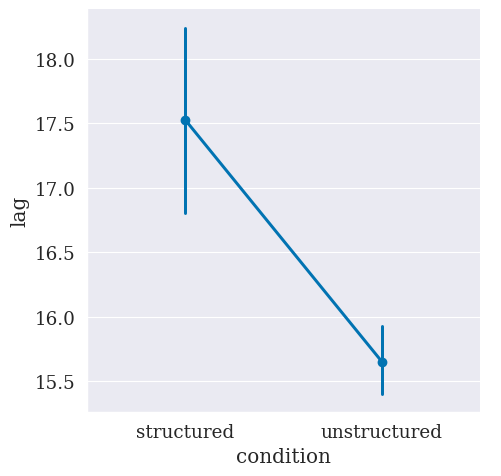

In [276]:
sns.catplot(
    x = 'condition',
    y = 'lag',
    data = df_clean_exposure_w_lag_averaged,
    kind = 'point'
)

In [274]:
lag_model = bmb.Model('lag ~ condition + (1|participant)', data = df_clean_exposure_w_lag_averaged.dropna())
lag_model_samples = lag_model.fit()


Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:07

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [277]:
az.summary(lag_model_samples, var_names = 'condition')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[unstructured],-1.868,0.516,-2.798,-0.883,0.01,0.007,2697.0,2878.0,1.0


In [255]:
model = bmb.Model('accuracy ~ lag + (1|participant)', data = df_clean_exposure_w_lag.dropna(), family = 'bernoulli')
samples = model.fit()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:02:49

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 169 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [278]:
az.summary(samples, var_names='lag')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lag,-0.002,0.001,-0.003,-0.001,0.0,0.0,2333.0,2650.0,1.0


Text(0, 0.5, 'Exposure Accuracy')

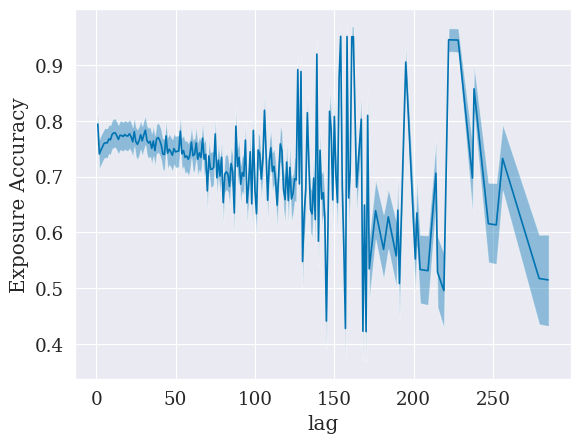

In [285]:
bmb.interpret.plot_predictions(model, samples, average_by = 'lag')
plt.ylabel('Exposure Accuracy')